In [104]:
import numpy as np
import pandas as pd
import pathlib
import os
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_pinball_loss,
)
import json

from utils_experiment import (
    load_data,
    get_model_list,
    plot_forecasts_analysis,
    rmse,
    pinball_loss,
    average_pinball_loss,
    plot_quantile_forecast
)

In [105]:




# for EXP_BASE in EXP_BASE_LIST:
#     EXP_MODEL_LIST = get_model_list(EXP_BASE)

#     for model_type in EXP_MODEL_LIST:
#         EXPERIMENT_NAME = f"{EXP_BASE}_{model_type}"
#         experiments.append(EXPERIMENT_NAME)

# experiments

Above is a list of all of the possible models, if you would like to limit which models are included:

In [106]:
exp_test_description = "Full_Report"
directory = f"/h/kupfersk/cfpr_2025/generate_forecasts/output/"

report_sim_dates = open("experiment_cutoff_dates.txt", 'r').read().split()

# report_sim_dates= report_sim_dates[1:-1]

target_categories = [
    'Bakery and cereal products (excluding baby food)',
     'Dairy products and eggs',
     'Fish, seafood and other marine products',
     'Food purchased from restaurants',
     'Food',
     'Fruit, fruit preparations and nuts',
     'Meat',
     'Other food products and non-alcoholic beverages',
     'Vegetables and vegetable preparations'
]


target_categories = [f"food_cpi: {col}" for col in target_categories]

start_years = [1986]
random_seed = 42

print("Target Categories:\n" + '\n'.join(target_categories))
print("Report Simulation Dates:\n" + '\n'.join(report_sim_dates))



file_path = "../data/processed_data/all_data_processed.csv"
all_data, foodprice_df, target_categories, all_covariates = load_data(target_categories, file_path)

Target Categories:
food_cpi: Bakery and cereal products (excluding baby food)
food_cpi: Dairy products and eggs
food_cpi: Fish, seafood and other marine products
food_cpi: Food purchased from restaurants
food_cpi: Food
food_cpi: Fruit, fruit preparations and nuts
food_cpi: Meat
food_cpi: Other food products and non-alcoholic beverages
food_cpi: Vegetables and vegetable preparations
Report Simulation Dates:
2018-07-01
2019-07-01
2020-07-01
2021-07-01
2022-07-01
2023-07-01


In [107]:

ignore_list = [".csv",
               "ipynb",
                "llama",
                "gemini",
                "claude",
                "gpt",
               "Mixtral",
               '5th',
               "restaurants",
               "DeepARModel_exp",
               "ChronosModel_exp",
               "PatchTSTModel_exp",
               "DLinearModel_exp",
               "exp7",
               "exp8",
               "corr",
               "economic",
               "human",
#                "GPT_P",
               "exp2_R"
               "llm",
               "exp1",
               "report",
               "local",
               "_R",
               "exp5",
               "DeepAR",
               "Simple"
               
]

experiments_include = []

for experiment_name in os.listdir(f"{directory}{'Full_Report'}"):
    if all(keyword not in experiment_name for keyword in ignore_list):
        experiments_include.append(experiment_name)

experiments_include

experiments = [exp for exp in experiments_include if 'exp1' in exp or 'exp2' in exp]
print(experiments)

['ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P3_', 'ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P1_', 'ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P4_', 'ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P2_']


In [108]:
# EXP_BASE_LIST = ["ag_local", "ag_global_cpi", "ag_global_with_covariates"]


# experiments = []
# for experiment_name in os.listdir(f"{directory}{exp_test_description}"):
#     if 'ipynb' not in experiment_name:
#         if '.csv' not in experiment_name:
#     #     if "ag" in experiment_name:
#             if "exp" not in experiment_name:
#                 experiments.append(experiment_name)


#         # # Read the file and store the content in a list
#         # llm_directory = '/h/kupfersk/cfpr_llm/Results_percentiles/Raw_data/'

#         # with open((llm_directory + 'llm_models.txt'), 'r') as file:
#         #     # Read all lines and strip any extra whitespace/newline characters
#         #     loaded_list = [line.strip() for line in file]


#         # experiments = experiments + loaded_list
# experiments

## Evaluation Metrics


In [109]:
point_metrics = {
    "r2_score": r2_score,
    "mae": mean_absolute_error,
    "mape": mean_absolute_percentage_error,
    "mse": mean_squared_error,
    "rmse": rmse,
}

In [110]:
def compute_all_scores(report_sim_dates, study_metric="mape"):
    global forecast_df
    global actual_df
    results = []
        
        
    # Load the dictionary from the JSON file
#     with open('../generate_forecasts/target_category_dict_filt.json', 'r') as json_file:
#         target_category_dict = json.load(json_file)

    for start_year in start_years:

        for EXPERIMENT_NAME in experiments:
            predicted_categories = target_categories
#             print(EXPERIMENT_NAME)
#             if 'ag' in EXPERIMENT_NAME :
#                 if 'exp' in EXPERIMENT_NAME: 
#                     general_experiment = f"exp{EXPERIMENT_NAME.split('_exp')[-1]}"
#                     predicted_categories_in = target_category_dict[general_experiment]
#                     # Drop items containing the word 'restaurant' or exactly 'food_cpi: Food'
#                     predicted_categories = [item for item in predicted_categories_in if 'restaurant' not in item.lower() and item != 'food_cpi: Food']
                    
#                 else:
#                     predicted_categories = target_categories
                
#             else:
#                 predicted_categories = [
#                                          'food_cpi: Bakery and cereal products (excluding baby food)',
#                                          'food_cpi: Meat',
#                                          'food_cpi: Vegetables and vegetable preparations'
#                                     ]

            for category in predicted_categories:
                if "restaurant" in category:
                    continue 
                    
                scores = []

                for cutoff_date in report_sim_dates:

                    forecast_csv_path = f"../generate_forecasts/output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_{random_seed}/{cutoff_date}/forecasts/{category}.csv"
                    forecast_df = pd.read_csv(forecast_csv_path, index_col=0)
                    forecast_df.index = pd.to_datetime(forecast_df.index)

                    actual_df = foodprice_df[category].loc[
                        [
                            date
                            for date in forecast_df.index
                            if date in foodprice_df.index
                        ]
                    ]
                    
                    if report_sim_dates[-1] == cutoff_date:
                        forecast_df = forecast_df.iloc[:-1]
                        actual_df = actual_df.iloc[:-1]


                    if study_metric in point_metrics:
                        median_col = "q_0.5"
                        y_pred = forecast_df[median_col]
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            point_metrics[study_metric](y_true=y_true, y_pred=y_pred)
                        )

                    elif study_metric == "pinball_loss":
                        y_pred = forecast_df
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            average_pinball_loss(
                                y_true=y_true,
                                y_pred_quantiles=y_pred,
                                quantiles=[
                                    0.01,
                                    0.05,
                                    0.1,
                                    0.25,
                                    0.75,
                                    0.9,
                                    0.95,
                                    0.99,
                                ],
                            )
                        )

                mean_score = np.mean(scores)
                std_score = np.std(scores)

                results.append(
                    {   "year": start_year,
                        "experiment": EXPERIMENT_NAME,
                        "category": category,
                        "mean_score": mean_score,
                        "std_score": std_score,
                        "scores": scores
                    }
                )

    return pd.DataFrame(results)

def compute_scores_single_ensemble(report_sim_dates, ensemble_experiments, study_metric="mape"):
    """
    This function computes scores for an ensemble of experiments.
    
    Parameters:
    - report_sim_dates: List of simulation dates.
    - ensemble_experiments: A list of experiment names that form the ensemble.
    - study_metric: The metric to be used for scoring ('mape' or 'pinball_loss').
    
    Returns:
    - A DataFrame with results (mean and std scores).
    """
    global forecast_df
    global forecast_dfs
    global actual_df
    results = []

    for start_year in start_years:
        # Join experiment names to track which ensemble is being processed
        experiment_names = '+'.join(ensemble_experiments)
        print(f"Processing ensemble: {experiment_names}")

        if any(name in experiment_names for name in ['llama', 'claude', 'gpt', 'gemini']):
               predicted_categories = [
                'food_cpi: Bakery and cereal products (excluding baby food)',
                'food_cpi: Meat',
                'food_cpi: Vegetables and vegetable preparations'
            ]
        else:
            predicted_categories = target_categories


        for category in predicted_categories:
            scores = []

            for cutoff_date in report_sim_dates:

                # Collect the forecasts for each experiment in the ensemble
                forecast_dfs = []
                for exp_name in ensemble_experiments:
                    forecast_csv_path = f"../generate_forecasts/output/{exp_test_description}/{exp_name}/random_seed_{random_seed}/{cutoff_date}/forecasts/{category}.csv"
                    forecast_df = pd.read_csv(forecast_csv_path, index_col=0)
                    forecast_df = forecast_df[['q_0.05','q_0.95','q_0.5']]
                    forecast_df.index = pd.to_datetime(forecast_df.index)
                    forecast_df = forecast_df.loc[forecast_df.index<='2024-07-01']
                    forecast_dfs.append(forecast_df)

                # Aggregate the forecasts (mean ensemble)
#                 mean_forecast_values = np.sum([df.values / len(ensemble_experiments) for df in forecast_dfs], axis=0)
                
    
    
                # Concatenate DataFrames with alignment on index, filling missing values with NaN
                aligned_forecasts = pd.concat(forecast_dfs, axis=1, keys=range(len(forecast_dfs)))

                # Calculate the mean for each quantile, ignoring NaN values
                mean_q_0_05 = aligned_forecasts.xs('q_0.05', axis=1, level=1).mean(axis=1)
                mean_q_0_5 = aligned_forecasts.xs('q_0.5', axis=1, level=1).mean(axis=1)
                mean_q_0_95 = aligned_forecasts.xs('q_0.95', axis=1, level=1).mean(axis=1)

                # Combine the means back into a single DataFrame
                mean_forecast_df = pd.DataFrame({
                    'q_0.05': mean_q_0_05,
                    'q_0.5': mean_q_0_5,
                    'q_0.95': mean_q_0_95
                })    
                
                forecast_df = pd.DataFrame(mean_forecast_df, index=forecast_dfs[0].index, columns=forecast_dfs[0].columns)

                # Extract the actual values from the foodprice_df
                actual_df = foodprice_df[category].loc[
                    [
                        date
                        for date in forecast_df.index
                        if date in foodprice_df.index
                    ]
                ]

                # Handle the case where the forecast and actual data have different lengths
                if report_sim_dates[-1] == cutoff_date:
                    forecast_df = forecast_df.iloc[:-1]
                    actual_df = actual_df.iloc[:-1]
      

                # Score the aggregated forecast using the specified metric
                if study_metric in point_metrics:
                    median_col = "q_0.5"
                    y_pred = forecast_df[median_col]
                    y_true = actual_df
                    if len(y_pred) > len(y_true):
                        y_pred = y_pred[: len(y_true)]
                    scores.append(
                        point_metrics[study_metric](y_true=y_true, y_pred=y_pred)
                    )

            # Calculate mean and std deviation of the scores
            mean_score = np.mean(scores)
            std_score = np.std(scores)

            # Append the result for the current category and ensemble configuration
            results.append(
                {
                    "year": start_year,
                    "experiment": experiment_names,
                    "category": category,
                    "mean_score": mean_score,
                    "std_score": std_score,
                    "scores": scores
                }
            )

    # Return the result as a DataFrame
    return pd.DataFrame(results)



In [111]:
mape_df = compute_all_scores(report_sim_dates, 'mape')
mape_df

,year,experiment,category,mean_score,std_score,scores
0,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Bakery and cereal products (excludin...,0.038190,0.035548,"[0.018224074543321752, 0.01271455186428442, 0...."
1,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Dairy products and eggs,0.028687,0.014741,"[0.021830581925373113, 0.02485608967749263, 0...."
2,1986,ag_global_all_TemporalFusionTransformerModel_e...,"food_cpi: Fish, seafood and other marine products",0.021464,0.016533,"[0.013389707090844477, 0.011075559378500145, 0..."
3,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Food,0.021489,0.017288,"[0.018821305568175736, 0.005071698156869697, 0..."
4,1986,ag_global_all_TemporalFusionTransformerModel_e...,"food_cpi: Fruit, fruit preparations and nuts",0.031481,0.020521,"[0.018787713047919243, 0.01953027558995098, 0...."
5,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Meat,0.024875,0.011759,"[0.01212864117484809, 0.012952361380156424, 0...."
6,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Other food products and non-alcoholi...,0.031651,0.026561,"[0.009557410596677042, 0.011857803779353212, 0..."
7,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Vegetables and vegetable preparations,0.055107,0.022773,"[0.0849194841260708, 0.033510938030742274, 0.0..."
8,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Bakery and cereal products (excludin...,0.040697,0.035836,"[0.016562558686402978, 0.014638308140249516, 0..."
9,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Dairy products and eggs,0.031833,0.012953,"[0.01962703799626859, 0.033297076380871524, 0...."


In [115]:
from itertools import combinations
from tqdm import tqdm

all_exp_results = []

for category in foodprice_df.columns:
    print(f"Computing ensemble scores for: {category}")
    all_combinations = []

    # Iterate through combinations of experiments for the ensemble (from 1 to 5 experiments in ensemble)
    for r in range(4, 5):
        # Select top 10 experiments based on lowest mean_score for the specific category
        top_experiments = mape_df.loc[mape_df.category == category].sort_values('mean_score').head(10)['experiment']

        # Generate all combinations of the experiments for this category
        exp_combinations = combinations(top_experiments, r)
        all_combinations.extend(exp_combinations)

    exp_results = []
    
    # Iterate over each unique experiment configuration (combination of experiments)
    for exp_config in tqdm(set(all_combinations)):
        # Call the compute_scores_single_ensemble function with each combination of experiments
        exp_results.append(
            compute_scores_single_ensemble(
                report_sim_dates=report_sim_dates,  # Use your date range here
                ensemble_experiments=list(exp_config),  # Pass current combination of experiments
                study_metric="mape"  # or another metric if needed
            )
        )
    
    # Extend the results across all categories
    all_exp_results.extend(exp_results)

Computing ensemble scores for: food_cpi: Bakery and cereal products (excluding baby food)


  0%|          | 0/1 [00:00<?, ?it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P3_+ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P4_+ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P1_+ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P2_


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Computing ensemble scores for: food_cpi: Dairy products and eggs


  0%|          | 0/1 [00:00<?, ?it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P3_+ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P4_+ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P1_+ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P2_


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Computing ensemble scores for: food_cpi: Fish, seafood and other marine products


  0%|          | 0/1 [00:00<?, ?it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P1_+ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P2_+ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P3_+ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P4_


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Computing ensemble scores for: food_cpi: Food purchased from restaurants


0it [00:00, ?it/s]


Computing ensemble scores for: food_cpi: Food


  0%|          | 0/1 [00:00<?, ?it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P4_+ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P3_+ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P1_+ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P2_


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Computing ensemble scores for: food_cpi: Fruit, fruit preparations and nuts


  0%|          | 0/1 [00:00<?, ?it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P3_+ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P1_+ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P4_+ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P2_


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Computing ensemble scores for: food_cpi: Meat


  0%|          | 0/1 [00:00<?, ?it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P2_+ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P4_+ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P3_+ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P1_


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Computing ensemble scores for: food_cpi: Other food products and non-alcoholic beverages


  0%|          | 0/1 [00:00<?, ?it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P3_+ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P1_+ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P4_+ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P2_


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Computing ensemble scores for: food_cpi: Vegetables and vegetable preparations


  0%|          | 0/1 [00:00<?, ?it/s]

Processing ensemble: ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P2_+ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P4_+ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P1_+ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P3_


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


In [116]:
forecast_dfs

[               q_0.05     q_0.95      q_0.5
 timestamp                                  
 2023-08-01  178.07292  192.96065  185.91869
 2023-09-01  174.71974  195.75110  184.60226
 2023-10-01  171.28801  197.65417  183.18898
 2023-11-01  169.45284  198.61122  182.37195
 2023-12-01  168.59889  199.33237  182.01695
 2024-01-01  172.22185  212.13792  187.68440
 2024-02-01  173.00998  213.05806  188.53784
 2024-03-01  173.41551  213.99570  189.28282
 2024-04-01  172.97961  215.33913  189.86550
 2024-05-01  171.87416  216.83180  190.10811
 2024-06-01  170.89070  217.58081  189.90851
 2024-07-01  170.08273  217.72247  189.43427,
                q_0.05     q_0.95      q_0.5
 timestamp                                  
 2023-08-01  176.87410  193.26927  185.14203
 2023-09-01  174.42660  193.23521  183.64821
 2023-10-01  173.35893  194.09613  183.38805
 2023-11-01  172.48897  195.59865  183.60533
 2023-12-01  170.47754  198.16682  183.48160
 2024-01-01  173.79008  208.26482  188.87814
 2024-02-

In [117]:
# all_combinations
mape_df = pd.concat(all_exp_results).reset_index(drop=True)

overall_mape = mape_df
overall_mape = overall_mape.drop(columns='scores')
overall_mape = overall_mape.drop_duplicates()

In [118]:
overall_mape.loc[overall_mape.category == 'food_cpi: Bakery and cereal products (excluding baby food)'].sort_values('mean_score')

,year,experiment,category,mean_score,std_score
0,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Bakery and cereal products (excludin...,0.040076,0.036782
27,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Bakery and cereal products (excludin...,0.040076,0.036782
18,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Bakery and cereal products (excludin...,0.040076,0.036782
36,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Bakery and cereal products (excludin...,0.040076,0.036782
45,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Bakery and cereal products (excludin...,0.040076,0.036782
63,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Bakery and cereal products (excludin...,0.040076,0.036782


In [125]:
best_results_year = []

for category in target_categories:
    # Filter rows for the current category
    category_rows = overall_mape.loc[overall_mape.category == category]
    
    # Get the top 5 experiments with the lowest mean_score
    top_rows = category_rows.nsmallest(1, "mean_score")
    
    # Append the results to the list
    for _, row in top_rows.iterrows():
        best_results_year.append(
            {
                "category": category,
                "top_experiment": row["experiment"],
                "mean_score": row["mean_score"],
                "std_score": row["std_score"],

            }
        )

best_results_year_df = pd.DataFrame(best_results_year)
best_results_year_df.to_csv(
    f"./best_results_ensembles_personas_final.csv", index=False
)
best_results_year_df



,category,top_experiment,mean_score,std_score
0,food_cpi: Bakery and cereal products (excludin...,ag_global_all_TemporalFusionTransformerModel_e...,0.040076,0.036782
1,food_cpi: Dairy products and eggs,ag_global_all_TemporalFusionTransformerModel_e...,0.030786,0.012534
2,"food_cpi: Fish, seafood and other marine products",ag_global_all_TemporalFusionTransformerModel_e...,0.020563,0.016006
3,food_cpi: Food purchased from restaurants,ag_global_all_TemporalFusionTransformerModel_e...,0.014082,0.011938
4,food_cpi: Food,ag_global_all_TemporalFusionTransformerModel_e...,0.022072,0.018778
5,"food_cpi: Fruit, fruit preparations and nuts",ag_global_all_TemporalFusionTransformerModel_e...,0.031762,0.019366
6,food_cpi: Meat,ag_global_all_TemporalFusionTransformerModel_e...,0.025223,0.009512
7,food_cpi: Other food products and non-alcoholi...,ag_global_all_TemporalFusionTransformerModel_e...,0.033741,0.029529
8,food_cpi: Vegetables and vegetable preparations,ag_global_all_TemporalFusionTransformerModel_e...,0.049447,0.019872


In [126]:
#Plot Multiple windows"
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def plot_quantile_forecasts_multiple(category, context_df, forecast_dfs_sets, actual_df, cutoff_dates, save_path=None, show_plots=True, model_name="", plot_mean=False):

    # Define a list of visually pleasing colors to be used for the different methods
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Hex color codes from a color-blind-friendly palette

    # Special color for "Mean Forecast"
    mean_forecast_color = 'gold'  # Magenta for prominence

    fig, ax = plt.subplots(figsize=(12,3))

    # Context
    context_df = pd.concat((context_df, actual_df))
    ax.plot(context_df.index, context_df.values, color='black', label='Historical CPI')

    # Store the unique legend elements
    legend_elements = {}

     # This flag ensures that if plot_mean is True, other methods are skipped
    found_mean_forecast = False

    for set_index, (method_name, forecast_dfs) in enumerate(forecast_dfs_sets):
        
        # If plot_mean is True, skip all methods that are not "Mean Forecast"
        if plot_mean and method_name != 'Mean Forecast':
            continue

        # If plot_mean is False, skip the "Mean Forecast"
        if not plot_mean and method_name == 'Mean Forecast':
            continue

        if method_name == 'Mean Forecast':
            found_mean_forecast = True  # Set the flag to True since we've encountered the "Mean Forecast"
            color = mean_forecast_color
            alpha_fill = 0.5  # Less transparency for the mean forecast, making it more prominent
            alpha_line = 1.0  # Solid line for the median of the mean forecast
        else:
            color = colors[set_index % len(colors)]  # Cycle through colors list
            alpha_fill = 0.2  # More transparency for the filled area
            alpha_line = 0.8  # Less transparency for the line

        for forecast_df in forecast_dfs:
            # Confidence range between 0.05 and 0.95 quantiles
            ax.fill_between(
                forecast_df.index,
                forecast_df["q_0.05"],
                forecast_df["q_0.95"],
                facecolor=color,
                alpha=alpha_fill,
                label=f'{method_name} 90% Confidence'
            )

            # Add a line trace for the median
            median_line = ax.plot(
                forecast_df.index,
                forecast_df["q_0.5"],
                color=color,
                alpha=alpha_line,
            )[0]  # ax.plot returns a list of line2D objects

        # Create unique legend elements. It prevents duplication in the legend for the same method.
        legend_elements[f'{method_name} 90% Confidence'] = plt.Rectangle((0,0),1,1,fc=color, edgecolor='none', alpha=alpha_fill)

    # Update the layout as needed
    ax.set_title(f'{category}\nRetrospective Forecast\n{model_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('CPI (% 2002 Prices)')
    for cutoff_date in cutoff_dates:
        ax.axvline(pd.to_datetime(cutoff_date), color='black', ls='--', ms=1, alpha=0.5)

    # Adding legend elements for each method
    ax.legend(legend_elements.values(), legend_elements.keys(), loc='upper left')

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    # Show the figure
    plt.grid(axis='y')

    if show_plots:
        plt.show()

#     # Save the figure if the path is specified
#     if save_path:
#         fig.savefig(save_path, dpi=300 if save_path.endswith("png") else None, transparent=True, bbox_inches='tight')  # High res for png

# Usage example:
# plot_quantile_forecasts_multiple(category, context_df, [("Method1", forecast_dfs1), ("Method2", forecast_dfs2)], actual_df, cutoff_dates, save_path=save_path)


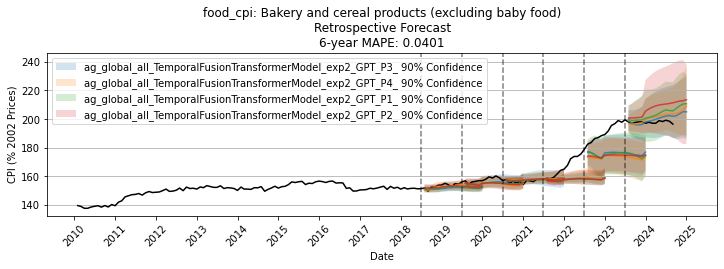

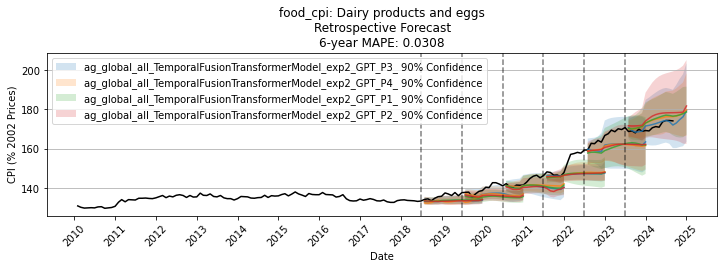

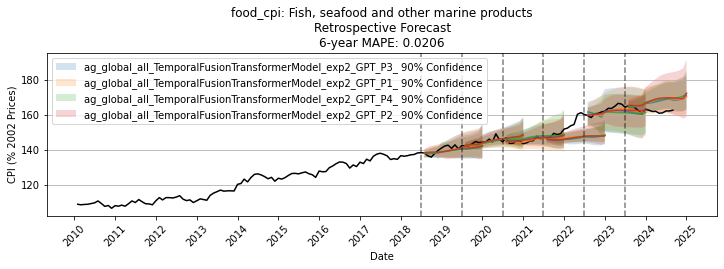

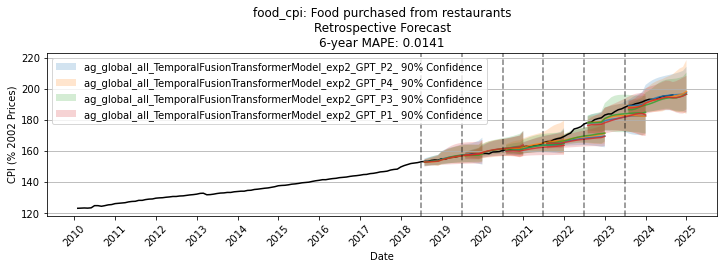

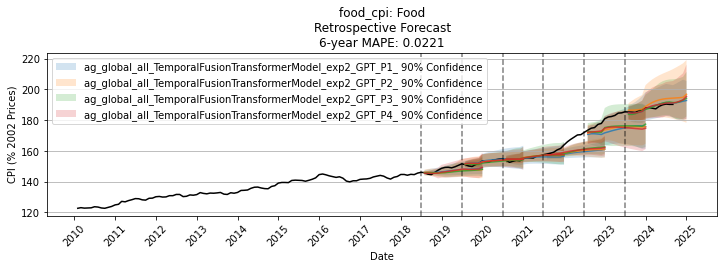

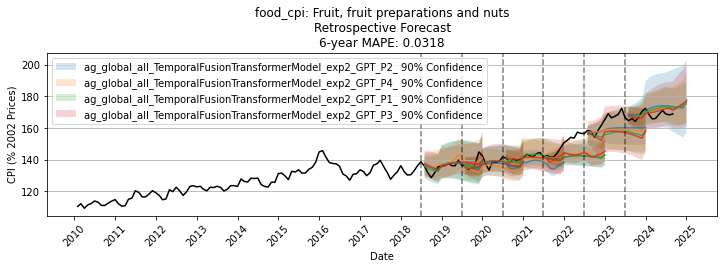

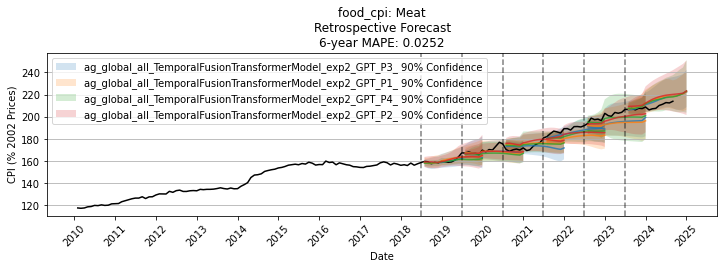

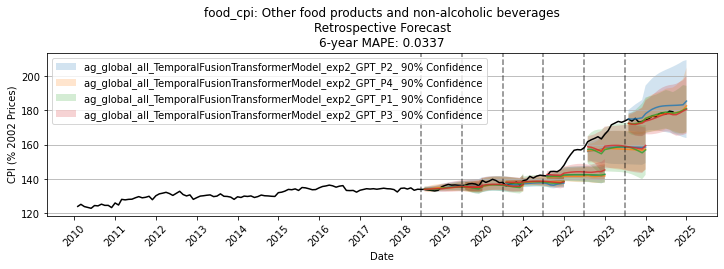

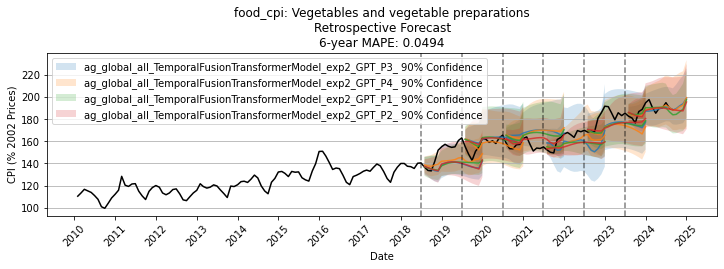

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

cutoff_dates = report_sim_dates

for index, (category, top_experiment, mean_score, std_score) in best_results_year_df.iterrows():
    ensemble_experiments = top_experiment.split('+')

    ensemble_forecast_data = []

    for ensemble_experiment in ensemble_experiments:
        forecast_dfs = []
        for date in cutoff_dates:
            forecast_csv_path = f"../generate_forecasts/output/Full_Report/{ensemble_experiment}/random_seed_{random_seed}/{date}/forecasts/{category}.csv"
            forecast_df = pd.read_csv(forecast_csv_path, index_col=0).iloc[-18:]
            forecast_df.index = pd.to_datetime(forecast_df.index)
            forecast_dfs.append(forecast_df)

        ensemble_forecast_data.append((ensemble_experiment, forecast_dfs))

    context_df = foodprice_df.loc[(foodprice_df.index > "2010-01-01") & (foodprice_df.index <= cutoff_dates[0])][category]
    actual_df = foodprice_df.loc[foodprice_df.index >= cutoff_dates[0]][category]

    save_path = f"./output/experiment_analysis/plots/{category}_best_ensemble_forecast.png"  # Replace with the actual path if you're saving plots

    # plot for multiple ensemble methods, including the mean forecast if applicable
    plot_quantile_forecasts_multiple(category, context_df, ensemble_forecast_data, actual_df, cutoff_dates, model_name=f"6-year MAPE: {mean_score:.4f}", save_path=save_path, plot_mean=False)

In [122]:
results = []
# Iterate through each row in best_results_year_df (Table 1)
for _, best_row in best_results_year_df.iterrows():
    category = best_row['category']
    top_experiment = best_row['top_experiment']
    mean_score_best = best_row['mean_score']
    
    # Find matching rows in mape_df (Table 2) based on category
    matching_rows = mape_df[mape_df['category'] == category]
    
    # Iterate through matching rows and check if the experiment matches the top_experiment
    for _, mape_row in matching_rows.iterrows():
        if top_experiment in mape_row['experiment']:
            if mean_score_best == mape_row['mean_score']:
                if category == mape_row['category']:

                    # Store the result (category, top_experiment, mean_score, etc.)
                    results.append({
                        'category': category,
                        'top_experiment': top_experiment,
                        'mean_score_best': best_row['mean_score'],
                        'mean_score_mape': mape_row['mean_score'],
                        'std_score': mape_row['std_score'],
                        'scores': mape_row['scores']
                    })
                    break

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

,category,top_experiment,mean_score_best,mean_score_mape,std_score,scores
0,food_cpi: Bakery and cereal products (excludin...,ag_global_all_TemporalFusionTransformerModel_e...,0.040076,0.040076,0.036782,"[0.014496409388168312, 0.014884957956893331, 0..."
1,food_cpi: Bakery and cereal products (excludin...,ag_global_all_TemporalFusionTransformerModel_e...,0.040076,0.040076,0.036782,"[0.014496409388168312, 0.014884957956893331, 0..."
2,food_cpi: Bakery and cereal products (excludin...,ag_global_all_TemporalFusionTransformerModel_e...,0.040076,0.040076,0.036782,"[0.014496409388168322, 0.01488495795689335, 0...."
3,food_cpi: Bakery and cereal products (excludin...,ag_global_all_TemporalFusionTransformerModel_e...,0.040076,0.040076,0.036782,"[0.014496409388168322, 0.014884957956893322, 0..."
4,food_cpi: Bakery and cereal products (excludin...,ag_global_all_TemporalFusionTransformerModel_e...,0.040076,0.040076,0.036782,"[0.014496409388168322, 0.014884957956893331, 0..."
5,food_cpi: Bakery and cereal products (excludin...,ag_global_all_TemporalFusionTransformerModel_e...,0.040076,0.040076,0.036782,"[0.014496409388168322, 0.014884957956893327, 0..."
6,food_cpi: Dairy products and eggs,ag_global_all_TemporalFusionTransformerModel_e...,0.030786,0.030786,0.012534,"[0.021143053917052932, 0.028372672794943037, 0..."
7,food_cpi: Dairy products and eggs,ag_global_all_TemporalFusionTransformerModel_e...,0.030786,0.030786,0.012534,"[0.021143053917052918, 0.02837267279494305, 0...."
8,food_cpi: Dairy products and eggs,ag_global_all_TemporalFusionTransformerModel_e...,0.030786,0.030786,0.012534,"[0.021143053917052932, 0.028372672794943037, 0..."
9,food_cpi: Dairy products and eggs,ag_global_all_TemporalFusionTransformerModel_e...,0.030786,0.030786,0.012534,"[0.021143053917052956, 0.02837267279494305, 0...."


In [123]:
results_df

,category,top_experiment,mean_score_best,mean_score_mape,std_score,scores
0,food_cpi: Bakery and cereal products (excludin...,ag_global_all_TemporalFusionTransformerModel_e...,0.040076,0.040076,0.036782,"[0.014496409388168312, 0.014884957956893331, 0..."
1,food_cpi: Bakery and cereal products (excludin...,ag_global_all_TemporalFusionTransformerModel_e...,0.040076,0.040076,0.036782,"[0.014496409388168312, 0.014884957956893331, 0..."
2,food_cpi: Bakery and cereal products (excludin...,ag_global_all_TemporalFusionTransformerModel_e...,0.040076,0.040076,0.036782,"[0.014496409388168322, 0.01488495795689335, 0...."
3,food_cpi: Bakery and cereal products (excludin...,ag_global_all_TemporalFusionTransformerModel_e...,0.040076,0.040076,0.036782,"[0.014496409388168322, 0.014884957956893322, 0..."
4,food_cpi: Bakery and cereal products (excludin...,ag_global_all_TemporalFusionTransformerModel_e...,0.040076,0.040076,0.036782,"[0.014496409388168322, 0.014884957956893331, 0..."
5,food_cpi: Bakery and cereal products (excludin...,ag_global_all_TemporalFusionTransformerModel_e...,0.040076,0.040076,0.036782,"[0.014496409388168322, 0.014884957956893327, 0..."
6,food_cpi: Dairy products and eggs,ag_global_all_TemporalFusionTransformerModel_e...,0.030786,0.030786,0.012534,"[0.021143053917052932, 0.028372672794943037, 0..."
7,food_cpi: Dairy products and eggs,ag_global_all_TemporalFusionTransformerModel_e...,0.030786,0.030786,0.012534,"[0.021143053917052918, 0.02837267279494305, 0...."
8,food_cpi: Dairy products and eggs,ag_global_all_TemporalFusionTransformerModel_e...,0.030786,0.030786,0.012534,"[0.021143053917052932, 0.028372672794943037, 0..."
9,food_cpi: Dairy products and eggs,ag_global_all_TemporalFusionTransformerModel_e...,0.030786,0.030786,0.012534,"[0.021143053917052956, 0.02837267279494305, 0...."


# Plot quantile forecasts for each category

In [124]:
# Assuming your DataFrame is named 'df' and the column with MAPE lists is 'scores'
# Create a new DataFrame to store the expanded columns for each evaluation window
expanded_df = pd.DataFrame()

# Loop through each row in the original DataFrame
for index, row in results_df.iterrows():
    mape_list = row['scores']  # Assuming the column with MAPE lists is named 'scores'
    
    # Create a dictionary for the new row
    new_row = {
        'experiment': row['top_experiment'],    # Retain experiment name
        'category': row['category'],        # Retain category
        'scores': row['scores']                 # Retain path
    }
    
    # Add each evaluation window's score as a new column
    for i, score in enumerate(mape_list):
        new_row['eval_window_'+report_sim_dates[i]] = score
    
    # Append the new row to the expanded DataFrame
    expanded_df = expanded_df.append(new_row, ignore_index=True)
expanded_df


AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_category(df, category):

    # Assuming `expanded_df` is the DataFrame from the previous step with columns for each evaluation window
    #Set the index to 'experiment' for better visualization
    df.set_index('experiment', inplace=True)
    
    # Select only the columns related to evaluation windows (eval_window_0, eval_window_1, ...)
    eval_columns = [col for col in df.columns if 'eval_window_' in col]

    # Create the heatmap using seaborn
    plt.figure(figsize=(15, 12))  # Adjust the size of the heatmap as needed
    sns.heatmap(df[eval_columns], annot=True, cmap='coolwarm', linewidths=0.5)

    # Set the title and labels
    plt.title(f'Heatmap of Evaluation Window Scores For {category} Across Experiments', fontsize=16)
    plt.xlabel('Evaluation Windows')
    plt.ylabel('Experiment')

    # Show the heatmap
    plt.show()

In [ ]:
for category in target_categories:
    df_filt = expanded_df.sort_values('experiment').loc[expanded_df['category']==category]
    plot_category(df_filt, category)

In [ ]:
expanded_df.sort_values('experiment')